# Explaining zero shot learning


see [Explaining transformer models using SHAP](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter07/Explaining_Transformers.ipynb)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(123)

import shap
print(f"Shap version used: {shap.__version__}")
import transformers
print(f"Hugging Face transformer version used: {transformers.__version__}")
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline
from typing import Union, List

Shap version used: 0.40.0


2022-06-04 18:51:21.198517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 18:51:21.198557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Hugging Face transformer version used: 4.19.1


In [2]:
# Loading the hugging face model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-3")
tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-3")

In [3]:
# Create a custom pipeline that only requires the text parameter 
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

    def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [4]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [5]:
text = ["I love playing cricket!"]
labels = ["insect","sports", "animal"]

In [6]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})


In [7]:
pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipe.set_labels(labels)

In [8]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

2022-06-04 18:51:55.314463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-04 18:51:55.329112: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-04 18:51:55.329174: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-2c88cb): /proc/driver/nvidia/version does not exist
2022-06-04 18:51:55.386163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/42 [00:00<?, ?it/s]

Partition explainer: 2it [00:38, 38.98s/it]               


In [9]:
score_and_visualize(text, shap_values)


Model predictions are: [[{'label': 'sports', 'score': 0.8340912461280823}, {'label': 'insect', 'score': 0.1633782535791397}, {'label': 'animal', 'score': 0.0025305524468421936}]]


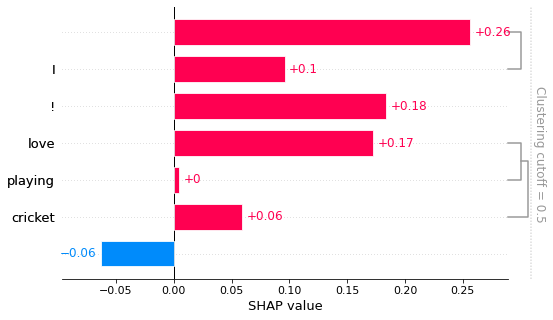

In [10]:
# Let's visualize the feature importance towards the outcome - sports
shap.plots.bar(shap_values[0,:,'sports'])